In [56]:
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from torchvision import models
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3


In [57]:
import os
print(os.getcwd())
root_path = r"/home/ramy/Ramy/chestxray"  # Use 'r' before the string to avoid slash errors
os.chdir(root_path)
print(f"Current Directory: {os.getcwd()}")

/home/ramy/Ramy/chestxray
Current Directory: /home/ramy/Ramy/chestxray


In [58]:
from chestxray_module.dataset import data_load, transform
from chestxray_module.modeling.predict import adjust
from torch.utils.data import DataLoader

# test loader
raw_data = data_load(data_dir="data/interim/cleaned_data/test", recursive=True, inspect=False)
transformed_data = transform(raw_data, "test") # test split transformation. no augmentation.
adjusted_data = adjust(transformed_data)
input_data = DataLoader(
                adjusted_data,
                batch_size = 32,
                shuffle=False,
                num_workers=0,
                pin_memory=True,
                )

len(adjusted_data)

Transformation done successfully.


1431

In [59]:
#Collect pixel statistics

import numpy as np
from tqdm import tqdm

def collect_pixel_stats(dataloader):
    means, stds = [], []

    for batch in tqdm(dataloader, desc="Collecting pixel stats"):
        imgs = batch["image"]  # (B, C, H, W)
        imgs = imgs.cpu().numpy()

        batch_means = imgs.mean(axis=(1, 2, 3))
        batch_stds  = imgs.std(axis=(1, 2, 3))

        means.extend(batch_means)
        stds.extend(batch_stds)

    return np.array(means), np.array(stds)


In [ ]:
ref = np.load("references/pixel_stats.npz")
train_means = ref["image_means"]
train_stds  = ref["image_stds"]
train_centroid = np.load("references/feature_centroid.npy")





array([0.05478516, 0.13355066, 0.42319298, ..., 0.22852294, 0.05111564,
       0.4892583 ], shape=(11534,), dtype=float32)

In [64]:
inf_means, inf_stds = collect_pixel_stats(input_data)


In [65]:
# KS test (drift detection)

from scipy.stats import ks_2samp

ks_mean = ks_2samp(train_means, inf_means)
ks_std  = ks_2samp(train_stds, inf_stds)

print("KS test – mean intensity:", ks_mean)
print("KS test – std intensity :", ks_std)


KS test – mean intensity: KstestResult(statistic=np.float64(0.024748875411886417), pvalue=np.float64(0.4099993643709752), statistic_location=np.float32(0.37592354), statistic_sign=np.int8(-1))
KS test – std intensity : KstestResult(statistic=np.float64(0.03674476469592469), pvalue=np.float64(0.0627013675125111), statistic_location=np.float32(1.141474), statistic_sign=np.int8(1))


In [66]:
#Feature extraction (DenseNet penultimate layer)
import torch
from sklearn.metrics.pairwise import cosine_distances

def extract_features(model, dataloader):
    model.eval()
    features = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting features"):
            imgs = batch["image"].to(DEVICE)

            x = model.features(imgs)
            x = torch.relu(x)
            x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
            x = x.view(x.size(0), -1)  # (B, F)

            features.append(x.cpu().numpy())

    return np.vstack(features)


In [ ]:
model = models.densenet121(weights=None)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
       nn.Linear(in_features, NUM_CLASSES)
    )
    
model.load_state_dict(torch.load("models/best_model.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

inf_feats = extract_features(model, input_data)
inf_centroid = inf_feats.mean(axis=0, keepdims=True)
cos_dist = cosine_distances(train_centroid, inf_centroid)[0][0]



Extracting features: 100%|██████████| 45/45 [00:23<00:00,  1.88it/s]


In [74]:
cos_dist

np.float32(0.00016331673)

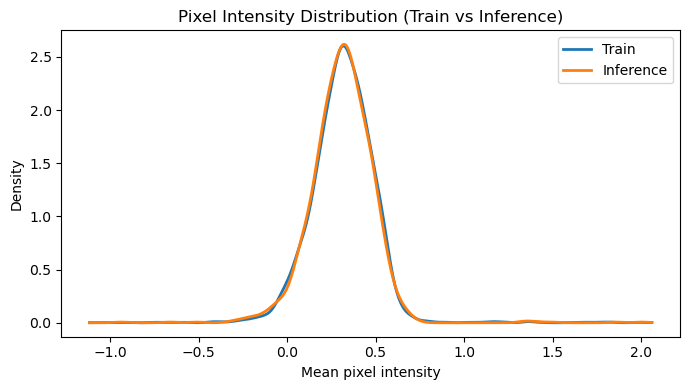

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(
    min(train_means.min(), inf_means.min()),
    max(train_means.max(), inf_means.max()),
    500
)

plt.figure(figsize=(7, 4))

plt.plot(x, gaussian_kde(train_means)(x), label="Train", linewidth=2)
plt.plot(x, gaussian_kde(inf_means)(x), label="Inference", linewidth=2)

plt.xlabel("Mean pixel intensity")
plt.ylabel("Density")
plt.title("Pixel Intensity Distribution (Train vs Inference)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()



In [55]:
train_means
# inf_means

array([0.1535113 , 0.28640226, 0.5073516 ], dtype=float32)